# [Como os usuários de um fórum de música avaliam os Beatles?](https://www.youtube.com/watch?v=UbW-_MRe3M8&ab_channel=CesarMorais)
César de Paula Morais - 2021031521

O [Fórum Steve Hoffman](https://forums.stevehoffman.tv/forums/music-corner.2/) é um dos mais tradicionais da internet, e nele podemos encontrar diversas threads de discussão sobre a banda The Beatles.<br>
O objetivo desse trabalho é encontrar insights sobre as opiniões de fãs de Beatles quanto a seus álbuns favoritos. Consequentemente, geraremos um dataset com valores de positividade (entre -1 e 1) por comentário, por álbum. <br>
Para isso, faremos um web scraping do fórum e encontraremos comentários pertinentes a álbuns dos Beatles. Quando encontrado, usaremos o [Analisador de Sentimento VADER](https://github.com/cjhutto/vaderSentiment) para gerar a positividade de tal comentário - é um valor entre -1 e 1.

Ao final, com o novo dataset, iremos analisar os resultados.


## Setup inicial
Primeiramente, precisamos:
- setar headers do navegador: para que o web scraping do fórum funcione;
- iniciar o VADER.

O VADER foi escolhido como ferramenta para análise de sentimento pois é "lexicon and rule-based", ou seja, quantifica o sentimento a partir de um dicionário léxico e algumas regras. Essa abordagem não foi vista no curso, mas é uma ótima alternativa a métodos de Machine Learning como BERT pois é computacionalmente mais eficiente. Como são centenas de milhares de comentários, demonstrou ser uma ótimo alternativa. <br>
Além disso, o modelo é especificamente tunado para frases de **redes sociais**, informais e com gírias em inglês, o que claramente encaixa com o tipo de comentário que esperaríamos em um fórum. 

In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

load_dotenv()
headers = os.getenv("STEVE_HOFFMAN_HEADERS")
STEVE_HOFFMAN_HEADERS = json.loads(headers)

analyzer = SentimentIntensityAnalyzer()

## Listagem de álbuns dos Beatles, via Wikipedia
A ideia inicial era buscar os álbuns dos Beatles via Wikipedia, porém foi necessário alterar manualmente alguns álbuns:
- retirada de álbuns desinteressantes para análise (bootlegs, principalmente);
- melhoria de títulos ("Help!" para "Help", muito mais utilizado, por exemplo);
- substituição do álbum "The Beatles" por "White Album", forma mais comum de referência ao álbum duplo de 1968. 

In [ ]:
# Gets album from Wikipedia's "Discography" page, given its url
def get_albums_from_wikipedia(url):
    response = requests.get(url)
    
    if response.status_code != 200:
        raise Exception(f"Failed to fetch the page. Status code: {response.status_code}")
    
    soup = BeautifulSoup(response.text, "html.parser")
    
    tables = soup.find_all("table", {"class": "wikitable"})
    
    albums = set()
    
    for table in tables:
        rows = table.find_all("tr")
        for row in rows:
            cells = row.find_all("th")
            if cells:
                album_name = cells[0].get_text(strip=True)
                if album_name and album_name != "Title":
                    albums.add(album_name)
    
    return sorted(albums)

def write_albums_to_csv(albums, filename):
    try:
        with open(filename, mode="w", newline="", encoding="utf-8") as file:
            writer = csv.writer(file)
            writer.writerow(["Album Name"])
            for album in albums:
                album = re.sub(r"\[.*?\]", "", album).strip()
                writer.writerow([album])
        print(f"Successfully wrote {len(albums)} albums to {filename}.")
    except Exception as e:
        print(f"Error writing to CSV: {e}")
albums_wikipedia = get_albums_from_wikipedia("https://en.wikipedia.org/wiki/The_Beatles_albums_discography")
write_albums_to_csv(albums_wikipedia, "artists/the_beatles_wikipedia.csv")

albums = []
with open('artists/the_beatles.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if row:
            albums.append(row[0].strip())
            
try:
    with open("albums_result.json", "r", encoding="utf-8") as f:
        albums_dict = json.load(f)
except FileNotFoundError:
    albums_dict = {album: [] for album in albums}

Successfully wrote 136 albums to artists/the_beatles_wikipedia.csv.


## Listagem das threads com "Beatles" no título
Para direcionar a busca pelos comentários, primeiramente listamos threads do fórum apenas com a palavra "Beatles" no título. O resultado foi salvo em `forum_threads.csv`.

In [6]:
def scrape_forum_threads(base_url, search_query, max_pages=30):
    threads = []
    session = requests.Session()
    session.headers.update(STEVE_HOFFMAN_HEADERS)

    for page in range(1, max_pages + 1):
        print(f"Scraping page {page}...")
        url = f"{base_url}?page={page}&q={search_query}&c[node]=2&o=relevance"
        
        response = session.get(url)
        if response.status_code != 200:
            print(f"Failed to fetch page {page}. Status code: {response.status_code}")
            break
        
        soup = BeautifulSoup(response.text, "html.parser")
        thread_elements = soup.find_all("h3", class_="title")
        
        if not thread_elements:
            print("No more threads found. Stopping.")
            break
        
        # Extract thread names and URLs
        for thread in thread_elements:
            link = thread.find("a")
            if link:
                thread_name = link.text.strip()
                thread_url = link["href"]
                if (thread_name not in (thread['name'] for thread in threads)):
                    threads.append({
                        "name": thread_name,
                        "url": f"https://forums.stevehoffman.tv/{thread_url}"
                    })
    
    return threads

base_url = "https://forums.stevehoffman.tv/search/12915788"
search_query = "beatles"
threads = scrape_forum_threads(base_url, search_query)

with open("forum_threads.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["name", "url"])
    writer.writeheader()
    writer.writerows(threads)
print("Threads saved to forum_threads.csv")


Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...
Scraping page 17...
Scraping page 18...
Scraping page 19...
Scraping page 20...
Scraping page 21...
No more threads found. Stopping.
Threads saved to forum_threads.csv


## Busca por comentários e análise de sentimento
Finalmente, podemos explorar todos os comentários das threads listadas anteriormente. <br>
A lógica é simples: caso haja a menção de algum álbum no comentário ou no título da thread, analisaremos o sentimento e adicionaremos esse valor em um dicionário `albums_dict`.<br>
O dataset final é salvo no arquivo `albums_result.json`.

In [ ]:
# for each thread
for thread in threads:
    print(f"Running on thread: {thread['name']}, {thread['url']}")
    albums_on_title = [album for album in albums if (album in thread['name'] and album != "The Beatles" and album != "Love")]

    # Get total pages for the thread
    session = requests.Session()
    session.headers.update(STEVE_HOFFMAN_HEADERS)

    response = session.get(thread['url'])
    soup = BeautifulSoup(response.text, "html.parser")
    pagination = soup.find("span", class_="pageNavHeader")
    try:
        number_of_pages = int(pagination.get_text(strip=True).split("of")[-1].strip())
    except:
        number_of_pages = 1

    # for each page
    for i in range(1, number_of_pages+1):
        url = thread['url'] if i == 1 else f"{thread['url']}?page={i}"
        response = session.get(url)
        if response.status_code != 200:
            print(f"Failed to fetch page {thread['url']} page {i}. Status code: {response.status_code}")
            break
        
        soup = BeautifulSoup(response.text, "html.parser")
        comments = soup.find_all("blockquote", class_="messageText")

        # for each comment
        for idx, comment in enumerate(comments, start=1):
            comment_text = comment.get_text(strip=True, separator=" ")  # Get all text with whitespace cleaned
            
            albums_in_comment = { album for album in albums if re.search(rf'\b{re.escape(album)}\b', comment_text, re.IGNORECASE) }
            albums_in_comment.update(albums_on_title)

            score = analyzer.polarity_scores(comment_text)['compound']
            
            for album in albums_in_comment:
                print(f"{album}: {score}")
                print(f"\t{comment_text}")
                albums_dict[album].append(score)
    
    # Save data after each thread
    with open("albums_result.json", "w", encoding="utf-8") as f:
        json.dump(albums_dict, f, ensure_ascii=False, indent=4)

print(albums_dict)

## Resultados

In [28]:
with open("albums_result.json", "r") as file:
    data = json.load(file)

album_scores_df = pd.DataFrame([
    {"Album": album, "Score": score}
    for album, scores in data.items()
    for score in scores
])

album_scores_df.describe()

,Score
count,126192.000000
mean,0.612285
std,0.481007
min,-0.992100
25%,0.423400
50%,0.842700
75%,0.958800
max,0.999800


A geração do dataset é algo extremamente importante, em si - no total, tivemos mais de 126 mil sentimentos registrados!<br>
Também é importante comentar que a análise de resultado deve levar em consideração o contexto de cada álbum - se é considerado "canônico" (um lançamento principal da banda), se é uma compilação, se é muito/pouco falado, etc.<br>
Nesse notebook apresentarei alguns insights gerais e que julgo interessantes, mas o dataset pode ser explorado muito mais!

A média geral foi de score igual a 0.6, com desvio padrão 0.48. Ou seja, tivemos uma ampla maioria de comentários positivos - isso também se confirma ao analisarmos o 1o quartil - valor 0.42.

Plotando agora um violin plot de cada álbum e um gráfico de barras com a média:

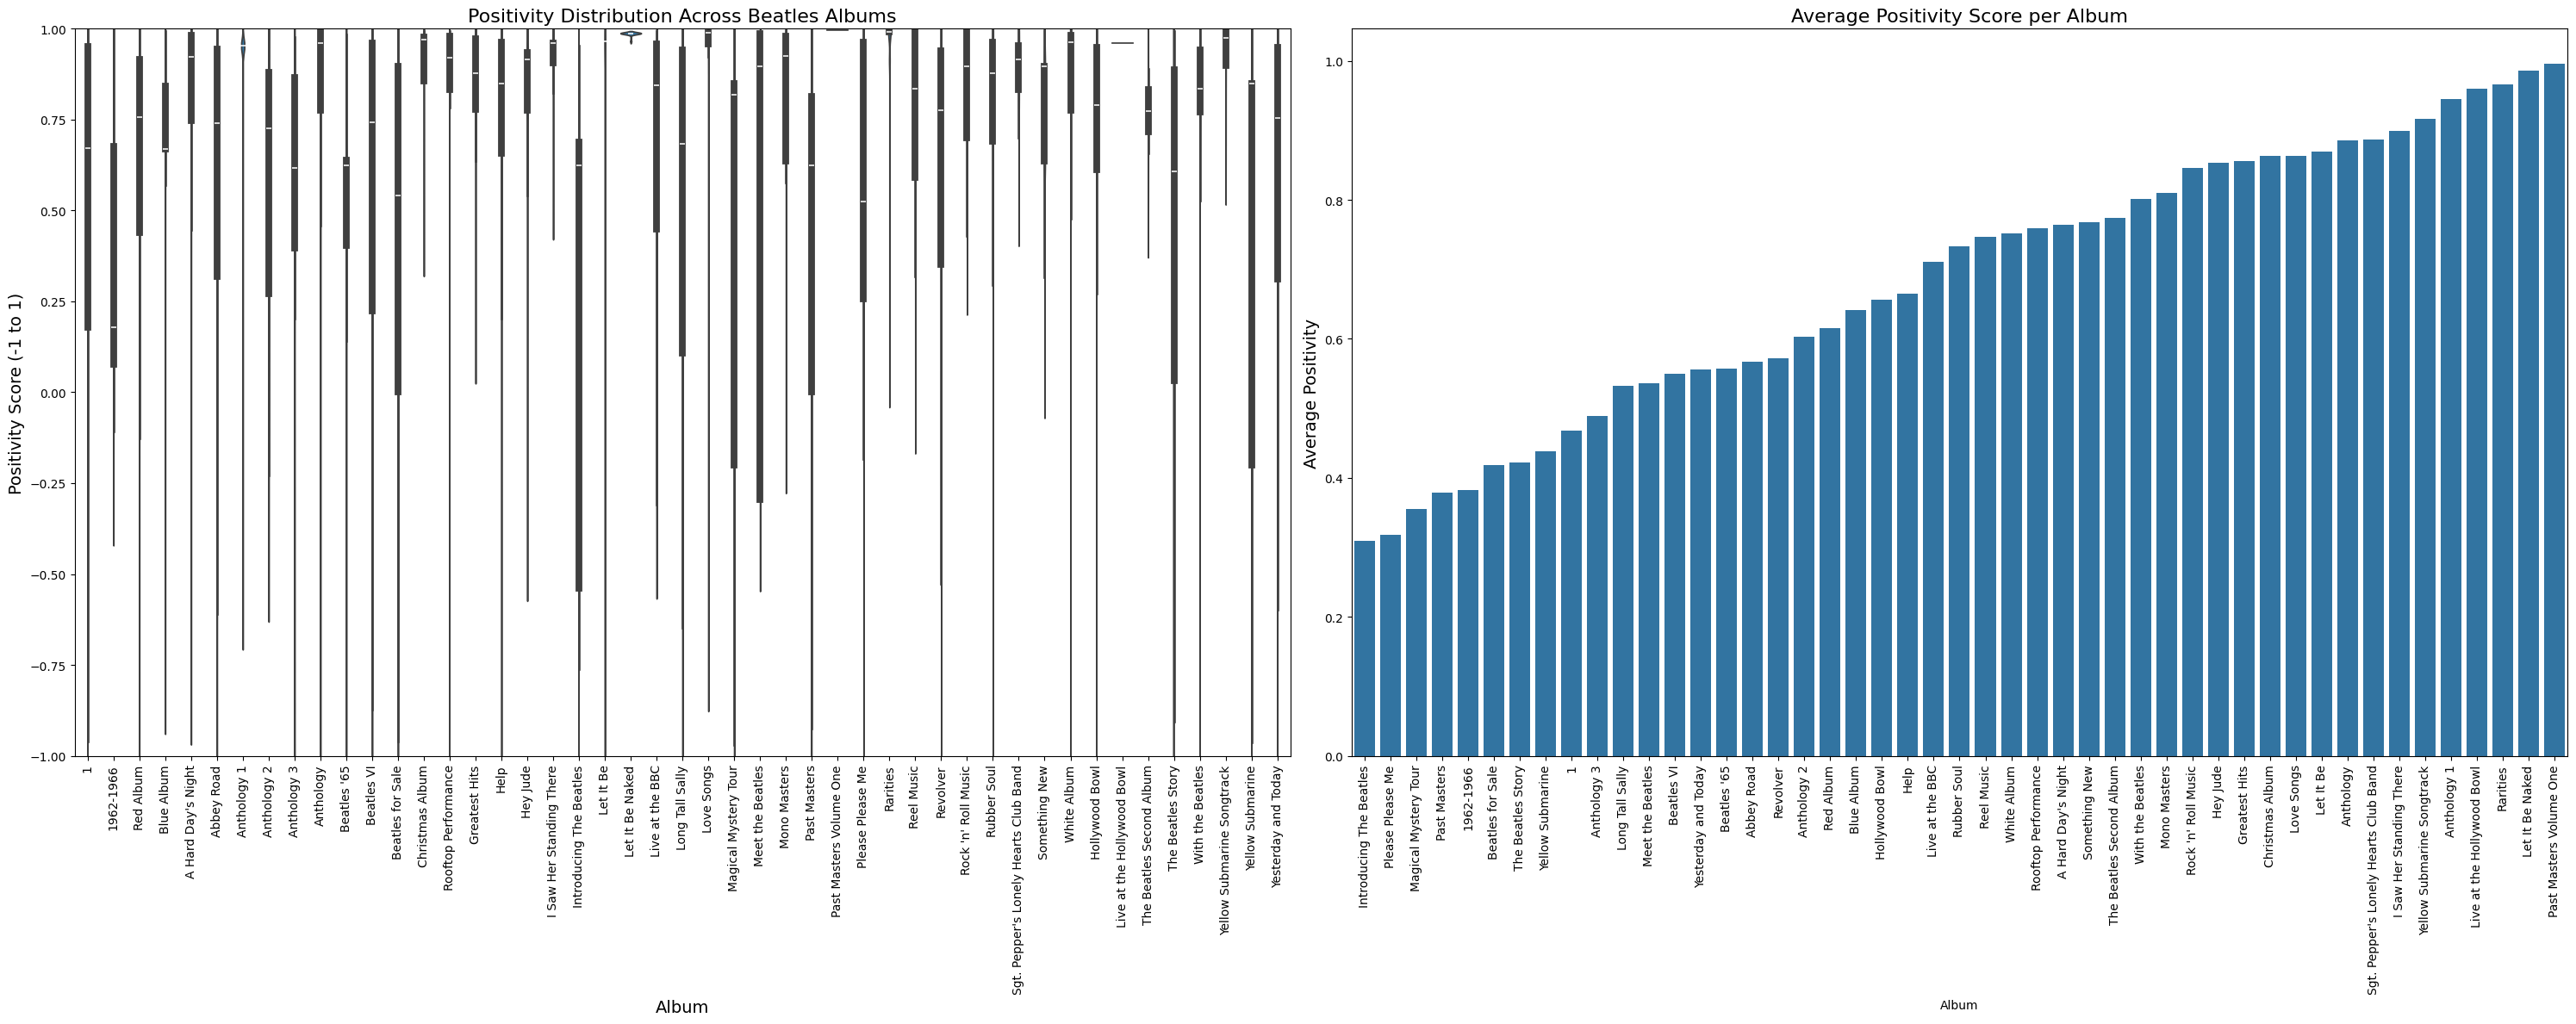

In [29]:
averages = album_scores_df.groupby('Album')['Score'].mean().reset_index().sort_values(by='Score', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(30, 12))

sns.violinplot(ax=axes[0], x="Album", y="Score", data=album_scores_df)
axes[0].set_title("Positivity Distribution Across Beatles Albums", fontsize=16)
axes[0].set_xlabel("Album", fontsize=14)
axes[0].set_ylabel("Positivity Score (-1 to 1)", fontsize=14)
axes[0].set_ylim(-1, 1)
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(ax=axes[1], x="Album", y="Score", data=averages)
axes[1].set_title("Average Positivity Score per Album", fontsize=16)
axes[1].set_ylabel("Average Positivity", fontsize=14)
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Percebe-se que a maioria dos álbuns teve uma variância pequena, e uma média de positividade acima de 0.3.<br>
Alguns dos álbuns mais bem avaliados (Past Masters Volume One, Let it Be Naked, Rarities e Live at The Hollywood Bowl) tiveram poucos comentários associados (são álbuns menos conhecidos/comentados), mas um valor de sentimento alto - e, por isso, ficaram em primeiro lugar no gráfico.

Analisaremos agora os chamados "álbuns canônicos", plotados em ordem de lançamento. A linha pontilhada vermelha é a média de scores desses álbuns:

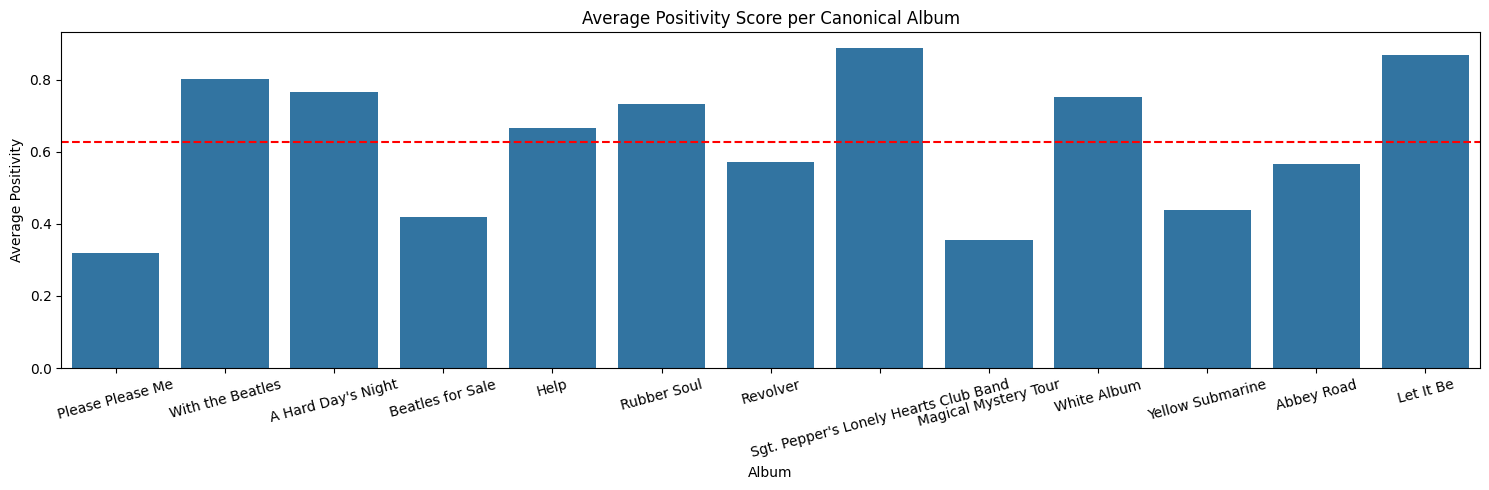

In [31]:
canon_albums = [ "Please Please Me", "With the Beatles", "A Hard Day's Night", "Beatles for Sale", "Help", "Rubber Soul", "Revolver", "Sgt. Pepper's Lonely Hearts Club Band",
                "Magical Mystery Tour", "White Album", "Yellow Submarine", "Abbey Road", "Let It Be"]

averages_canon = (
    album_scores_df[album_scores_df['Album'].isin(canon_albums)]
    .groupby('Album')
    .agg(Score=('Score', 'mean'), StdDev=('Score', 'std'))
    .reset_index()
)

averages_canon['Album'] = pd.Categorical(averages_canon['Album'], categories=canon_albums, ordered=True)
mean_score = averages_canon['Score'].mean()

plt.figure(figsize=(15, 5))
sns.barplot(x="Album", y="Score", data=averages_canon)
plt.axhline(y=mean_score, color='red', linestyle='--', label=f"Mean: {mean_score:.2f}")

plt.title("Average Positivity Score per Canonical Album")
plt.ylabel("Average Positivity")

plt.xticks(rotation=15,)

plt.tight_layout()
plt.show()

Em geral, não há uma correlação entre data de lançamento e a positividade do álbum. Além disso, discos considerados como os melhores de todos os tempos não necessariamente tiveram um score mais alto - mesmo que Sgt. Pepper's Lonely Hearts Club Band seja o primeiro lugar, temos Abbey Road e Revolver, por exemplo, com valores abaixo da média.

In [27]:
averages_canon.sort_values(by='Score', ascending=False)

,Album,Score,StdDev
9,Sgt. Pepper's Lonely Hearts Club Band,0.887130,0.102317
4,Let It Be,0.869399,0.284521
11,With the Beatles,0.801567,0.220048
0,A Hard Day's Night,0.764710,0.367487
10,White Album,0.751339,0.441524
8,Rubber Soul,0.732647,0.339193
3,Help,0.665521,0.444361
7,Revolver,0.572489,0.459415
1,Abbey Road,0.567519,0.450329
12,Yellow Submarine,0.438697,0.521059


Visualizando também o desvio padrão, percebe-se que o álbum "Sgt. Pepper's Lonely Hearts Club Band" está com o score mais alto, e também tem o menor desvio padrão, o que indica uma tendência de positividade extremamente alta nesse disco. Esse resultado não é surpreendente, já que o disco já foi considerado pela Rolling Stone como o maior de todos os tempos e é o primeiro "álbum conceitual" da história!

Finalmente, também é evidente uma tendência de desvio padrão maior quanto menor os scores. Isso pode apontar álbuns "divisivos", como é o caso dos 3 piores avaliados: "Please Please Me", "Magical Mystery Tour" e "Beatles For Sale".<br>
Curiosamente, o disco "Please Please Me", pior avaliado, é o álbum de estreia da banda.